# Exercise 09: Spectral Analysis of Network

In this week's exercise we use the spectral methods introduced in lecture 09 to analyse networks. In a first task we use the algebraic connectivity to quantify how ''well-connected'' a network is. In a second task we use the entries of the Fiedler vector to detect cluster structures in a simple synthetic example.

In [1]:
#BOILERPLATE_CODE
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np
import pathpy as pp

import scipy.linalg as la
import scipy.sparse as sparse
import scipy.sparse.linalg as sla

## Task 1: Algebraic connectivity of networks

### 1.1 Laplacian matrix and algebraic connectivity 

Implement two functions `laplacian` and `algconn` that return the Laplacian matrix and the algebraic connectivity of a given (undirected and unweighted) network.

In [2]:
#BOILERPLATE_CODE
def laplacian(n):
    # too easy
#     return n.laplacian_matrix(self, weighted=False, transposed=False)
    
    # self-made
    A = n.adjacency_matrix(weighted=False, transposed=False)
#     D = sparse.diags([n.nodes[v]['degree'] for v in n.nodes])
    D = sparse.diags(n.degrees())
    return D - A

def algconn(n):
#     eigenvalues = sla.eigs(laplacian(n),return_eigenvectors=False)
    eigenvalues = la.eigvalsh(laplacian(n).todense()) 
    return eigenvalues[1] # The eigenvalues are already sorted

Test your functions in the (standard) toy example used in Lecture 09. Compare the value of the algebraic connectivity to the value given in the lecture.

In [3]:
n = pp.Network()
n.add_edge('a', 'b')
n.add_edge('b', 'c')
n.add_edge('a', 'c')
n.add_edge('b', 'd')
n.add_edge('d', 'f')
n.add_edge('d', 'g')
n.add_edge('d', 'e')
n.add_edge('e', 'f')
n.add_edge('f', 'g')

print(laplacian(n).todense())
print('Algebraic connectivity: ', algconn(n))

[[ 2. -1. -1.  0.  0.  0.  0.]
 [-1.  3. -1. -1.  0.  0.  0.]
 [-1. -1.  2.  0.  0.  0.  0.]
 [ 0. -1.  0.  4. -1. -1. -1.]
 [ 0.  0.  0. -1.  3. -1. -1.]
 [ 0.  0.  0. -1. -1.  2.  0.]
 [ 0.  0.  0. -1. -1.  0.  2.]]
Algebraic connectivity:  0.39832086811684353


Remove the connecting edge `(b,d)` between the two clusters and recompute the algebraic connectivity.

In [4]:
n.remove_edge('b', 'd')

print(laplacian(n).todense())
print('Algebraic connectivity: ', algconn(n))

[[ 2. -1. -1.  0.  0.  0.  0.]
 [-1.  2. -1.  0.  0.  0.  0.]
 [-1. -1.  2.  0.  0.  0.  0.]
 [ 0.  0.  0.  3. -1. -1. -1.]
 [ 0.  0.  0. -1.  3. -1. -1.]
 [ 0.  0.  0. -1. -1.  2.  0.]
 [ 0.  0.  0. -1. -1.  0.  2.]]
Algebraic connectivity:  1.1102230246251565e-16


### 1.2 Algebraic connectivity in networks with cluster structures

Generate a network that consists of two separate connected components, each being a Erdoes-Renyi network with with $100$ nodes and $np =10$. For this task, you can use the $+$ operator in `pathpy`, which generates the union of two networks. Compute the algebraic connectivity of this network.

In [5]:
number_of_nodes = 100
np_ = 10.

g1 = pp.algorithms.random_graphs.erdoes_renyi_gnp(
    number_of_nodes,
    p=np_/number_of_nodes,
    node_names=range(100)
)
pp.algorithms.components.reduce_to_gcc(g1)

g2 = pp.algorithms.random_graphs.erdoes_renyi_gnp(
    number_of_nodes,
    p=np_/number_of_nodes,
    node_names=range(100,200)
)
pp.algorithms.components.reduce_to_gcc(g2)


g3 = g1 + g2
g3

Run a simulation where you repeatedly rewire two randomly chosen links from the graph by ''crossing'' the links, i.e. connect the source of the first edge to the target of the second edge and vice-versa. Compute the algebraic connectivity of the updated network after each rewiring. Plot the change of algebraic connectivity as you rewire an increasing number of $m$ links up to  $m=1000$.

In [6]:
#BOILERPLATE_CODE
def calc_algconn(g1, g2):
    m = min(g1.ecount(), g2.ecount(), 1000)
    algconns = []
    g3 = g1 + g2

    for i in range(m):

        nodes1 = [e for e in list(g3.edges) if e[0]<100 and e[1]<100]
        node11, node12 = nodes1[np.random.randint(len(nodes1))]

        nodes2 = [e for e in list(g3.edges) if e[0]>99 and e[1]>99]
        node21, node22 = nodes2[np.random.randint(len(nodes2))]

        g3.remove_edge(node11, node12)
        g3.remove_edge(node21, node22)

        g3.add_edge(node11, node22)
        g3.add_edge(node12, node21)

        algconns.append(algconn(g3))
        
    return algconns

We provide the following boilerplate code to plot the results:

In [7]:
#BOILERPLATE_CODE
def plot_algconn(g1, g2):
    fig = plt.figure()
    ax = plt.subplot(111)

    ax.plot(calc_algconn(g1, g2))

    ax.set_xlabel(r'$m$')
    ax.set_ylabel(r'$\lambda_2(\mathbf{\mathcal{L}})$')

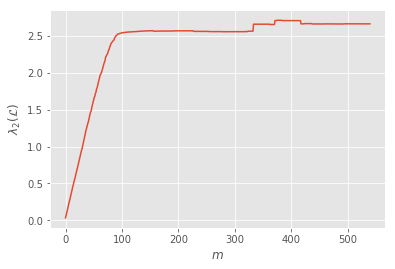

In [8]:
plot_algconn(g1, g2)

## Task 2: Spectral clustering of networks

### 2.1 The Fiedler vector

Write a function `fiedler` that computes the so-called **Fiedler vector** of a given undirected and unweighted network, i.e. the eigenvector corresponding to the algebraic connectivit of the Laplacian matrix, as defined in Lecture 09. 

In [9]:
#BOILERPLATE_CODE
def fiedler(network):
    L = laplacian(network)
    eigenvalues, eigenvectors = la.eig(L.todense(), left=True, right=False)
    return eigenvectors[:,1]

Test your function in the toy example from above. Compare the Fiedler vector entries with the results from lecture L09.

In [10]:
# n.add_edge('b','d')
# n.remove_edge('b','d')

fiedler(n)

array([-0.57735027, -0.57735027, -0.57735027,  0.        ,  0.        ,
        0.        ,  0.        ])

### 2.2 Spectral bisectioning with the Fiedler vector

Generate a modular network consisting of four $5$-regular networks with $20$ nodes each. Use `pathpy`'s $+$ operator to create the union of both networks and rewire a small number of arbitrary links in such a way that the four modules are connected in a single connected network (with strong cluster structure).

Visualise the resulting network to test your code.

In [11]:
nodes_per_network = 20
number_of_clusters = 5
number_of_crossconnections = 10
clusters = np.arange(number_of_clusters)

n2 = pp.Network()

for m in range(number_of_clusters):
    n_add = pp.algorithms.random_graphs.erdoes_renyi_gnp(
        nodes_per_network,
#         p=5/(nodes_per_network-1),
        p=.5,
        node_names=range(m*nodes_per_network, (m+1)*nodes_per_network),
        self_loops=False,
        directed=False
    )
    
#     n_add = pp.algorithms.random_graphs.molloy_reed(
#         [5]*nodes_per_network,
#         node_names=range(m*nodes_per_network, (m+1)*nodes_per_network)
#     )
    
    pp.algorithms.components.reduce_to_gcc(n_add)
    n2 += n_add
    
for m in range(number_of_crossconnections):
    np.random.shuffle(clusters)
    node1 = np.random.randint(nodes_per_network) + clusters[0] * nodes_per_network
    node2 = np.random.randint(nodes_per_network) + clusters[1] * nodes_per_network
    n2.add_edge(node1, node2)

In [12]:
n2

Use the function from above to compute the entries of the Fiedler vector of this network. Use `pathpy`'s `plot` function to color the nodes of the network according to the sign of the entries in the Fiedler vector. Plot the network and describe what you observe.

In [13]:
def colorize_network(network):
    fv = fiedler(network)
    node_colors ={}

    for i in network.nodes:
        if fv[i]<0:
            node_colors[i] = 'red'
        else:
            node_colors[i] = 'blue'

    pp.visualisation.plot(network, node_color=node_colors)

In [14]:
colorize_network(n2)

### 2.3 Recursive spectral clustering

Use the Fiedler vector to bisect, i.e. cut, the network into two different (disconnected) components and compute the algebraic connectivity of the two resulting networks. Recursively apply this bisectioning to the resulting components until you have detected all five clusters in the network. 

What would be a meaningful condition to stop the recursive bisectioning?  
**Answer:** We assign a threshold value to the *Algebraic connectivity* of approximately 1.

In [15]:
def spectral_clustering(network):
    
    fv = fiedler(network)
    
    if algconn(network)>1:
        return network
    
    else:
        g1 = pp.Network()
        g2 = pp.Network()

        for nInd, nVal in enumerate(network.nodes):
            if(fv[nInd] < 0):
                g1.add_node(nVal)
            else:
                g2.add_node(nVal)

        for e1, e2 in network.edges:
            if e1 in g1.nodes and e2 in g1.nodes:
                g1.add_edge(e1, e2)
            elif e2 in g2.nodes and e2 in g2.nodes:
                g2.add_edge(e1, e2)

        return g1, g2
    
def check_fiedler(list_of_networks):
    for n in list_of_networks:
        fv = fiedler(n)
        if all(fv>0.) or all(fv<0.):
            continue
        else:
            return False
        return True

def rsc(network):
    graphs = spectral_clustering(network)
    
    while not check_fiedler(graphs):
        new_graphs = []
        for g in graphs:
            new_graphs.append(spectral_clustering)
        graphs = new_graphs
    
    return graphs

In [16]:
graphs = spectral_clustering(n2)
print(algconn(g1), algconn(g2))

3.9535768854239115 2.583785088789574
